In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import jit, prange, objmode
import time

import tensorly as tl
from tensorly.decomposition import parafac

import CP_ALS3 as cp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor

In [2]:
@jit(nopython=True)
def generate_system(coo_tensor, vals, shape, mode, a, b, l2, step):
    #start = time.time()
    mtx = np.zeros((a.shape[1], a.shape[1]))
    right = np.zeros((a.shape[1]))
    mask = coo_tensor[:, mode] == step
    coo_step = coo_tensor[mask]
    vals_step = vals[mask]
    #print("Gen_0_start:", time.time() - start)
    
    #start = time.time()
    if mode == 0:
        mode_a = 1 
        mode_b = 2
        
    elif mode == 1:
        mode_a = 0
        mode_b = 2
        
    else:
        mode_a = 0
        mode_b = 1

    for i in range(a.shape[1]):
        for j in range(a.shape[1]):
            for item in range(coo_step.shape[0]):
                coord = coo_step[item]
                mtx[i, j] += (a[coord[mode_a], i] 
                              * b[coord[mode_b], i] 
                              * a[coord[mode_a], j] 
                              * b[coord[mode_b], j])
                if i == 0:
                    right[j] += a[coord[mode_a], j] * b[coord[mode_b], j] * vals_step[item]
            
            if i == j:
                mtx[i, j] += l2
    #print("Gen_0_end:", time.time() - start)
    return mtx, right

In [74]:
@jit(nopython=True, parallel=True)
def generate_system(coo_tensor, vals, shape, mode, a, b, l2, step):
    #start = time.time()
    mtx = np.zeros((a.shape[1], a.shape[1]))
    right = np.zeros((a.shape[1]))
    mask = coo_tensor[:, mode] == step
    coo_step = coo_tensor[mask]
    vals_step = vals[mask]
    #print("Gen_1_start:", time.time() - start)
    
    #start = time.time()
    if mode == 0:
        mode_a = 1 
        mode_b = 2
        
    elif mode == 1:
        mode_a = 0
        mode_b = 2
        
    else:
        mode_a = 0
        mode_b = 1
    
    for i in range(a.shape[1]):
        a_i = a[:, i]
        b_i = b[:, i]
        for j in range(a.shape[1]):
            a_j = a[:, j]
            b_j = b[:, j]
            temp_mtx = 0.0
            for item in range(coo_step.shape[0]):
                coord = coo_step[item]
                coo_a = coord[mode_a]
                coo_b = coord[mode_b]
                
                temp_mtx += (a_i[coo_a] 
                             * b_i[coo_b] 
                             * a_j[coo_a] 
                             * b_j[coo_b])
                
            mtx[i, j] = temp_mtx
            if i == j:
                mtx[i, j] += l2
    
    temp_right = 0
    for j in range(a.shape[1]):
        a_j = a[:, j]
        b_j = b[:, j]
        for item in range(coo_step.shape[0]):
            coord = coo_step[item]
            coo_a = coord[mode_a]
            coo_b = coord[mode_b]
            temp_right += a_j[coo_a] * b_j[coo_b] * vals_step[item]
            
        right[j] = temp_right           
    #print("Gen_1_end:", time.time() - start)
    return mtx, right

In [3]:
@jit(nopython=True)#, parallel=True)#, nogil=True) 
def wrcp_als3(coo_tensor,
              vals,
              shape,
              rank=5,
              l2=0.5,
              max_iter=50,
              tol=1e-8,
              show_iter=False):
    
    #start = time.time()
    a = np.random.normal(0.0, 0.1, size=(shape[0], rank))
    b = np.random.normal(0.0, 0.1, size=(shape[1], rank))
    c = np.random.normal(0.0, 0.1, size=(shape[2], rank))
    err_arr = np.empty((max_iter, 1))  
    #print("Init:", time.time() - start)
    
    it = 0
    err1 = 1.0
    err2 = 0.0
    tt = [0, 0, 0]
    while np.abs(err1 - err2) > tol:
        it += 1
        
        #start = time.time()
        for i in range(shape[0]):
            #start_ = time.time()
            A, right = generate_system(
                coo_tensor, vals, shape,
                0, b, c, l2, i,
            )
            
            #if i < 10:
            #    print("Generate: ", time.time() - start_)
            
            #start_ = time.time()
            #a[i, :] = np.linalg.pinv(A) @ right
            a[i, :] = np.linalg.solve(A, right)
            #a[i, :], _ = sp.sparse.linalg.cg(A, right)
            #if i < 10:
            #    print("Solve: ", time.time() - start_)
        #end = time.time()
        #tt[0] = end - start
        
        #start = time.time()
        for j in range(shape[1]):
            A, right = generate_system(
                coo_tensor, vals, shape,
                1, a, c, l2, j,
            )
            
            #b[j :] = np.linalg.pinv(A) @ right
            b[j :] = np.linalg.solve(A, right)
            #b[j, :], _ = sp.sparse.linalg.cg(A, right)
        #end = time.time()
        #tt[1] = end - start
        
        #start = time.time()
        for k in range(shape[2]):   
            A, right = generate_system(
                coo_tensor, vals, shape,
                2, a, b, l2, k,
            )
            
            #c[k, :] = np.linalg.pinv(A) @ right
            c[k, :] = np.linalg.solve(A, right)
            #c[k, :], _ = sp.sparse.linalg.cg(A, right)
        #end = time.time()
        #tt[2] = end - start
        
        #start = time.time()
        error = sqrt_err_relative(coo_tensor, vals, shape, a, b, c)
        err_arr[it - 1] = error
        err2 = err1
        err1 = error
        #print("Count err:", time.time() - start)
        
        if show_iter:
            print("Iter:", it, "Time(1, 2, 3):", tt, "\n")
        if it == max_iter:
            print("iterations over")
            break
    
    return a, b, c, err_arr, it

In [4]:
import pickle

In [5]:
entity_list = pickle.load(open('LP_Data/entity_list', 'rb'))
relation_list = pickle.load(open('LP_Data/relation_list', 'rb'))

train_triples = pickle.load(open('LP_Data/train_triples', 'rb'))
test_triples = pickle.load(open('LP_Data/test_triples', 'rb'))

entity_map = pickle.load(open('LP_Data/entity_map', 'rb'))
relation_map = pickle.load(open('LP_Data/relation_map', 'rb'))

In [6]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(14240, 1174, 14240)

In [7]:
max_iter = 2
rank = 15
l2 = 5e-3 

In [8]:
%%time
a, b, c, err_arr, it = wrcp_als3(
    coords,
    values,
    data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    show_iter=True,
)

Iter: 1 Time(1, 2, 3): [0, 0, 0] 

Iter: 2 Time(1, 2, 3): [0, 0, 0] 

iterations over
CPU times: user 1min 56s, sys: 612 ms, total: 1min 56s
Wall time: 1min 56s


In [9]:
rerr = sqrt_err_relative(
    coords,
    values,
    data_shape,
    a,
    b,
    c,
)
print(f"Relative error = {rerr}")

Relative error = 0.21598720540620325


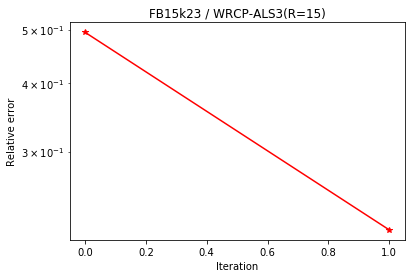

In [10]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"FB15k23 / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err_arr[:it], 'r-*')

# Random Matrix:

In [73]:
%%time
init_shape = (5000, 5100, 4000)
coo, vals = gen_coo_tensor(init_shape, density=0.00000002)
assert check_coo_tensor(coo)!= "Bad"
coo.shape[0]

CPU times: user 520 ms, sys: 108 µs, total: 521 ms
Wall time: 518 ms


2040

## WRCP-ALS3:

In [75]:
%%time
max_iter = 1
rank = 15
l2 = 1e-4
a, b, c, err, it = wrcp_als3(
    coo, vals, init_shape, rank=rank,
    l2=l2, max_iter=max_iter, show_iter=False
)
rerror = sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.00022377257401695553;
CPU times: user 322 ms, sys: 0 ns, total: 322 ms
Wall time: 320 ms


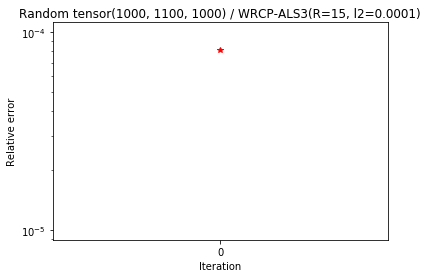

In [29]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor{init_shape} / WRCP-ALS3(R={rank}, l2={l2})")
plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

# Small Rank Matrix:

In [97]:
shape = (5, 7, 9)
rank = 3
ten = np.zeros(shape=shape)
p = np.zeros(shape=(shape[0], rank))
q = np.zeros(shape=(shape[1], rank))
r = np.zeros(shape=(shape[2], rank))
all_elem = np.prod(shape)
all_elem

315

In [98]:
p[0] = [1, 0, 0]
p[1] = [0, 1, 0]
p[2] = [0, 0, 1]

q[0] = [1, 0, 0]
q[1] = [0, 1, 0]
q[2] = [0, 0, 1]

r[0] = [1, 0, 0]
r[1] = [0, 1, 0]
r[2] = [0, 0, 1]

p[3] = [1, 1, 1]
q[3] = [1, 0, 1]
r[3] = [1, 0, 1]

p[4] = [1, 1, 1]
q[5] = [1, 0, 1]
r[6] = [1, 0, 1]
r[8] = [1, 1, 1]

In [99]:
coo = list()
vals = list()
nnz = 0
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            temp = np.sum(p[i, :] * q[j, :] * r[k, :])
            ten[i, j, k] = temp
            if temp != 0:
                vals.append(temp)
                coo.append((i, j, k))
                nnz += 1
coo = np.array(coo)
vals = np.array(vals)
nnz

66

## Let Max_Iter = 25:

In [100]:
max_iter = 25
rank = 3

## WRCP-ALS3:

In [104]:
%%time
l2 = 1e-4
a, b, c, err, it = wrcp_als3(coo, vals, shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.0011760785339784583;
CPU times: user 2.12 ms, sys: 0 ns, total: 2.12 ms
Wall time: 2.07 ms


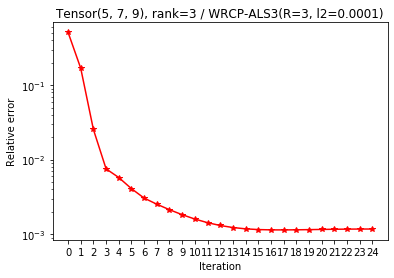

In [105]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank}, l2={l2})")
plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

## TensorLy:

In [107]:
(w, f), err = parafac(
    tensor=ten,
    rank=rank,
    n_iter_max=max_iter,
    init="random",
    random_state=1,
    return_errors=True,
)
rerror = sqrt_err_relative(coo, vals, shape, f[0], f[1], f[2])
print(f"Rel err = {rerror};")

Rel err = 0.0015587204424431446;


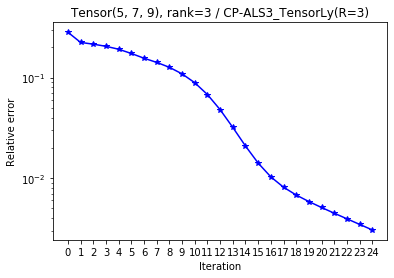

In [108]:
name = "CP-ALS3_TensorLy"
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / {name}(R={rank})")
plt.xticks(np.arange(len(err)))
plt.yscale("log")
plt.plot(np.arange(len(err)), err, 'b-*')

## CP-ALS3:

In [110]:
%%time
a, b, c, err, it = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.0015143139798518153;
CPU times: user 3.11 ms, sys: 0 ns, total: 3.11 ms
Wall time: 3.08 ms


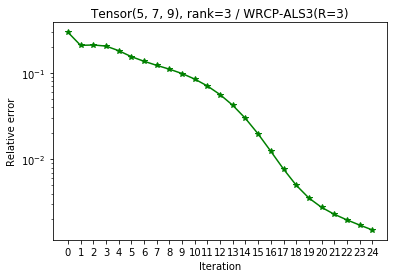

In [111]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank})")
plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'g-*')

## Let Max_Iter = 100:

In [112]:
max_iter = 100
rank = 3

## WRCP-ALS3:

In [128]:
%%time
l2 = 1e-10
a, b, c, err, it = wrcp_als3(coo, vals, shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

Rel err = 2.7328147481919225e-08;
CPU times: user 6.03 ms, sys: 0 ns, total: 6.03 ms
Wall time: 12.8 ms


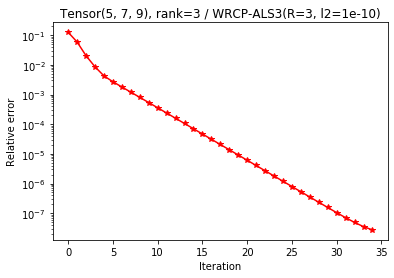

In [129]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank}, l2={l2})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

## TensorLy:

In [116]:
(w, f), err = parafac(
    tensor=ten,
    rank=rank,
    n_iter_max=max_iter,
    init="random",
    random_state=1,
    return_errors=True,
)
rerror = sqrt_err_relative(coo, vals, shape, f[0], f[1], f[2])
print(f"Rel err = {rerror};")

Rel err = 3.73182701766298e-08;


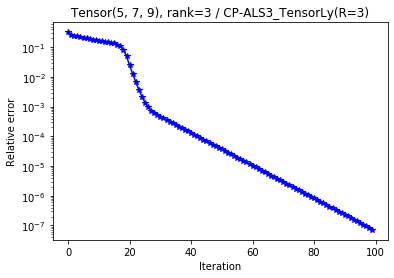

In [117]:
name = "CP-ALS3_TensorLy"
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / {name}(R={rank})")
#plt.xticks(np.arange(len(err)))
plt.yscale("log")
plt.plot(np.arange(len(err)), err, 'b-*')

## CP-ALS3:

In [118]:
%%time
a, b, c, err, it = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 2.355259855926625e-07;
CPU times: user 17.7 ms, sys: 9 µs, total: 17.7 ms
Wall time: 17.4 ms


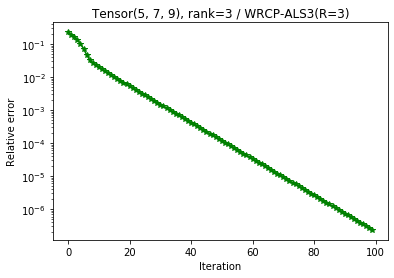

In [119]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'g-*')

## Tucker:

In [120]:
import polara.lib.hosvd as hosvd

In [144]:
%%time
core_shape = (3, 3, 3)
p, q, r, g = hosvd.tucker_als(
    idx=coo,
    val=vals,
    shape=shape,
    core_shape=core_shape,
    iters=100,
    growth_tol=0.01,
    batch_run=False,
    seed=None,
)

Step 1 of 100
growth of the core: 1.000000
Step 2 of 100
growth of the core: -0.000000
Core is no longer growing. Norm of the core: 10.099505
Done
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.1 ms


In [134]:
from numba import jit

In [130]:
@jit(nopython=True) 
def sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = 0.0
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        elem = 0.0
        for p in range(a.shape[1]):
            for q in range(b.shape[1]):
                for r in range(c.shape[1]):
                    elem += g[p, q, r] * a[coord[0], p] * b[coord[1], q] * c[coord[2], r]
        
        result += (vals[item] - elem)**2  
    return np.sqrt(result)

@jit(nopython=True) 
def sqrt_err_relative_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g)        
    return result / np.sqrt((vals**2).sum())

In [145]:
rerr = sqrt_err_relative_tucker(
    coo,
    vals,
    shape,
    p,
    q,
    r,
    g,
)
print(f"Relative error = {rerr}")

Relative error = 5.504112613176956e-16
